In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.grimoire as Grimoire

grim = Grimoire.Grimoire(omnicomprehensive=True)

In [26]:
from src.card import Format, Type, Filters
# Crea la matrice di correlazione
df = grim.dataframe( 
    filters=[
        Filters.isLegalInCommander,
        Filters.isCreature,
        Filters.isColorless
    ], 
    additional_data={
        # "is_creature": lambda card: int(Type.Creature.name in card.types),
        "#keywords" : lambda card: len(card.keywords),
        "#words" : lambda card: card.text.count(' ')+1,
        "is_green": lambda card: int(card.color_identity['G']),
        "is_black": lambda card: int(card.color_identity['B']),
        # "is_colorless": lambda card: int(all(not v for v in card.color_identity.values())),
        "is_legendary": lambda card: int("Legendary" in card.super_types),
        "act_abilities": lambda card: int(card.has_active_abilities()),
        "trigg_abilities": lambda card: int(card.has_trigger_abilities()),
        "mana_production": lambda card: int(card.has_mana_production())
    })

In [27]:
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
df_scaled[numeric_cols] =  StandardScaler().fit_transform(df[numeric_cols])
correlation_matrix = df_scaled.corr()

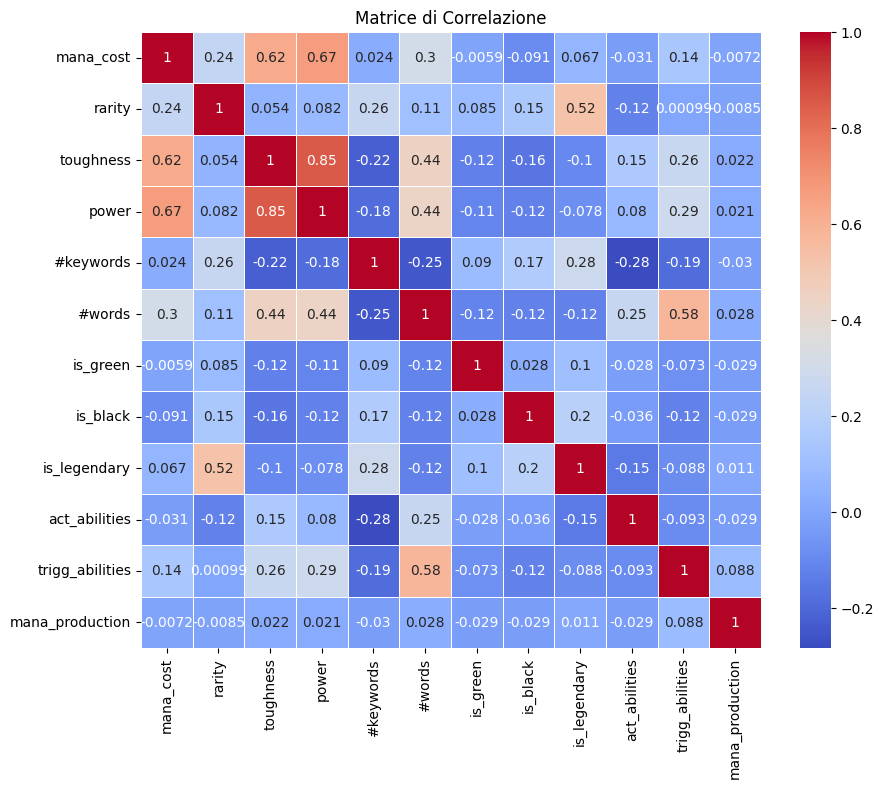

In [28]:

# Opzionalmente, crea una heatmap per visualizzare meglio la correlazione
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione')
plt.show()

print(correlation_matrix)